## Imports and settings

In [180]:
import os
import pandas as pd 
import numpy as np
import optuna
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [181]:
pd.set_option('display.max_columns', None)

## Loading data

In [182]:
df_monthly = pd.read_csv("df_monthly.csv", low_memory=False)

## Exploring data

In [183]:
df_monthly.shape

(24107, 44)

In [184]:
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24107 entries, 0 to 24106
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date_month                  24107 non-null  object 
 1   accounts_id                 24107 non-null  int64  
 2   plan_name                   24090 non-null  object 
 3   mrr                         22712 non-null  float64
 4   new_total_mentions          22178 non-null  float64
 5   sessions_nr                 16800 non-null  float64
 6   total_pageviews_nr          16800 non-null  float64
 7   min_pv_nr                   16800 non-null  float64
 8   max_pv_nr                   16800 non-null  float64
 9   avg_pv_nr                   16800 non-null  float64
 10  total_session_duration_min  16800 non-null  float64
 11  min_sess_min                16800 non-null  float64
 12  max_sess_min                16800 non-null  float64
 13  avg_sess_min                168

In [185]:
# Ensure 'date_month' is in datetime format
df_monthly['date_month'] = pd.to_datetime(df_monthly['date_month'])

In [186]:
print(df_monthly.shape)
df_monthly = df_monthly[df_monthly['date_month'] < "2024-01-01"]
print(df_monthly.shape)

(24107, 44)
(23663, 44)


In [187]:
percent_nan = df_monthly.isna().mean()
print(percent_nan)

date_month                    0.000000
accounts_id                   0.000000
plan_name                     0.000718
mrr                           0.058953
new_total_mentions            0.062756
sessions_nr                   0.290031
total_pageviews_nr            0.290031
min_pv_nr                     0.290031
max_pv_nr                     0.290031
avg_pv_nr                     0.290031
total_session_duration_min    0.290031
min_sess_min                  0.290031
max_sess_min                  0.290031
avg_sess_min                  0.290031
projects_count                0.736551
email_class                   0.000634
is_edu_email                  0.000634
register_platform             0.000634
is_client                     0.000634
web_mobile                    0.001902
first_device_type             0.074674
country_name                  0.000634
first_state                   0.023539
continent                     0.000634
is_unknown_region             0.002493
pgsql_landing            

In [188]:
# Sort DataFrame by 'accounts_id' and 'date_month'
df_monthly = df_monthly.sort_values(by=['accounts_id', 'date_month'])

# Calculate the subscription month as the rank of 'date_month' within each group of 'accounts_id'
df_monthly['subscription_month'] = df_monthly.groupby('accounts_id')['date_month'].rank(method='dense').astype(int)

In [189]:
print(df_monthly.date_month.min(), df_monthly.date_month.max())

2021-01-01 00:00:00 2023-12-01 00:00:00


In [190]:
df_monthly = df_monthly.drop(columns=["why_they_track", "projects_count", "is_client", "is_organic_sale"])

In [191]:
df_monthly.shape

(23663, 41)

In [192]:
#df_monthly = df_monthly.dropna()

In [193]:
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23663 entries, 0 to 24106
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date_month                  23663 non-null  datetime64[ns]
 1   accounts_id                 23663 non-null  int64         
 2   plan_name                   23646 non-null  object        
 3   mrr                         22268 non-null  float64       
 4   new_total_mentions          22178 non-null  float64       
 5   sessions_nr                 16800 non-null  float64       
 6   total_pageviews_nr          16800 non-null  float64       
 7   min_pv_nr                   16800 non-null  float64       
 8   max_pv_nr                   16800 non-null  float64       
 9   avg_pv_nr                   16800 non-null  float64       
 10  total_session_duration_min  16800 non-null  float64       
 11  min_sess_min                16800 non-null  float64       


In [194]:
additional_cols = ["date_month", "accounts_id"]

target_col = "next_month_churn"

num_cols = [
    "mrr",
    "new_total_mentions",
    "sessions_nr",
    "total_pageviews_nr",
    "min_pv_nr",
    "max_pv_nr",
    "avg_pv_nr",
    "total_session_duration_min",
    "min_sess_min",
    "max_sess_min",
    "avg_sess_min",
    "users_nr",    
    "users_limit",
    "subscription_month",
]

flag_cols = [
    "is_edu_email",
    "is_pre_individual",	
    "is_pst_individual",
    "is_pre_personal",
    "is_pst_personal",	
    "is_connected",	
    "is_pst_connected",
    "is_pre_demo",	
    "is_pst_demo",
    "is_twitter_enabled",
    "is_fb_integrated",
]

categorical_cols = [
    "plan_name",
    "email_class",
    "register_platform",
    "web_mobile",
    "first_device_type",
    "country_name",
    "first_state",
    "continent",
    "is_unknown_region",
    "pgsql_landing",
    "heap_landing",
    "first_landing",
    "landings_grouped",
]

In [195]:
for c in categorical_cols:
    print(c, "-",len(df_monthly[c].unique()))

plan_name - 5
email_class - 3
register_platform - 3
web_mobile - 3
first_device_type - 4
country_name - 120
first_state - 382
continent - 8
is_unknown_region - 3
pgsql_landing - 129
heap_landing - 139
first_landing - 132
landings_grouped - 4


In [196]:
# assign tablet to mobile class
df_monthly["first_device_type"] = df_monthly["first_device_type"].replace({"Tablet": "Mobile"})

In [197]:
# replace undefined continent with nan value
df_monthly["continent"] = df_monthly["continent"].replace({"undefined": np.nan})

In [198]:
df_monthly = df_monthly.drop(
    columns=[
        "country_name",
        "first_state",
        "pgsql_landing",
        "heap_landing",
        "first_landing",
    ]
)

In [199]:
categorical_cols = [c for c in categorical_cols if c not in [
    "country_name",
    "first_state",
    "pgsql_landing",
    "heap_landing",
    "first_landing",
]]

In [200]:
categorical_cols

['plan_name',
 'email_class',
 'register_platform',
 'web_mobile',
 'first_device_type',
 'continent',
 'is_unknown_region',
 'landings_grouped']

In [201]:
for c in flag_cols: 
    df_monthly[c] = df_monthly[c].astype(bool)

### Wypełnienie brakujących danych

In [202]:
df_monthly.isna().mean()[df_monthly.isna().mean() > 0]

plan_name                     0.000718
mrr                           0.058953
new_total_mentions            0.062756
sessions_nr                   0.290031
total_pageviews_nr            0.290031
min_pv_nr                     0.290031
max_pv_nr                     0.290031
avg_pv_nr                     0.290031
total_session_duration_min    0.290031
min_sess_min                  0.290031
max_sess_min                  0.290031
avg_sess_min                  0.290031
email_class                   0.000634
register_platform             0.000634
web_mobile                    0.001902
first_device_type             0.074674
continent                     0.001183
is_unknown_region             0.002493
landings_grouped              0.012424
users_nr                      0.000634
users_limit                   0.000634
dtype: float64

In [203]:
fillna_mode = [
    "plan_name",
    "email_class", 
    "register_platform", 
    "web_mobile", 
    "first_device_type", 
    "continent", 
    "is_unknown_region",
    "landings_grouped",
]

In [204]:
for c in fillna_mode:
    df_monthly[c] = df_monthly[c].fillna(df_monthly[c].mode()[0])

In [205]:
df_monthly["users_nr"] = df_monthly["users_nr"].fillna(int(df_monthly["users_nr"].mean()))

In [206]:
df_monthly["users_limit"] = df_monthly["users_limit"].fillna(10)

In [207]:
fill_zero = [
    "mrr",                 
    "new_total_mentions",
    "sessions_nr",
    "total_pageviews_nr",
    "min_pv_nr",          
    "max_pv_nr",          
    "avg_pv_nr",
    "total_session_duration_min",
    "min_sess_min",             
    "max_sess_min",             
    "avg_sess_min"
] 

In [208]:
for c in fill_zero:
    df_monthly[c] = df_monthly[c].fillna(0)

### Wizualizacja danych 

In [209]:
def plot_cat_vs_churn(df, cat_col):
    # Example aggregation by count
    churn_counts = df.groupby([cat_col, 'next_month_churn']).size().unstack(fill_value=0)
    
    # If you prefer proportions over counts
    churn_proportions = churn_counts.div(churn_counts.sum(axis=1), axis=0)
    
    # Plotting the churn counts
    churn_counts.plot(kind='bar', stacked=True, color=["#3075B1", "#003B6F"])
    plt.title(f'Churn Counts by {cat_col}')
    plt.xlabel(cat_col)
    plt.ylabel('Counts')
    plt.xticks(rotation=45)  # Rotate category labels for better readability
    plt.legend(title='Next Month Churn')
    plt.show()
    
    # Or, plotting the churn proportions
    churn_proportions.plot(kind='bar', stacked=True,color=["#3075B1", "#003B6F"])
    plt.title(f'Churn Proportions by {cat_col}')
    plt.xlabel(cat_col)
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)  # Rotate category labels for better readability
    plt.legend(title='Next Month Churn')
    plt.show()

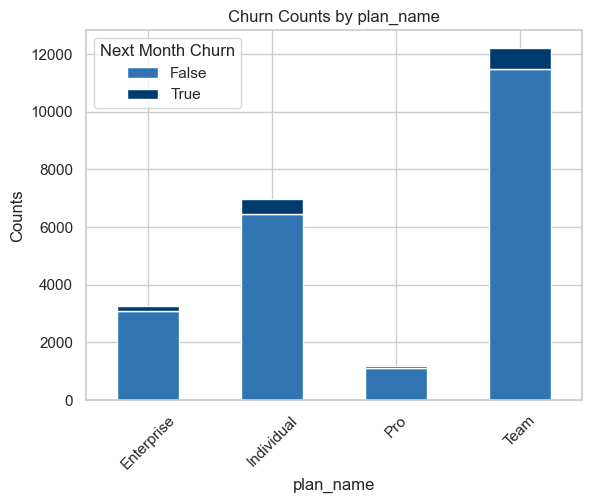

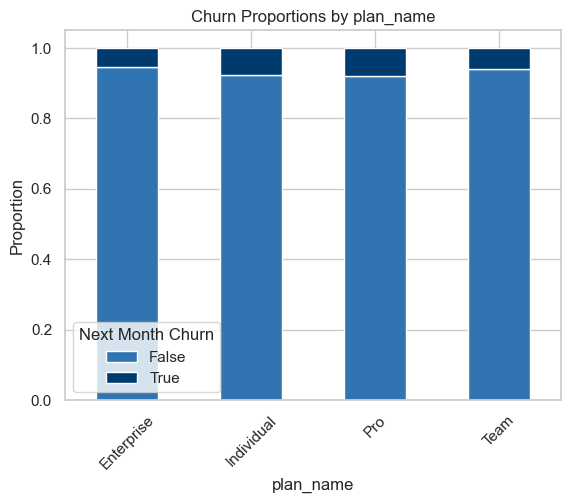

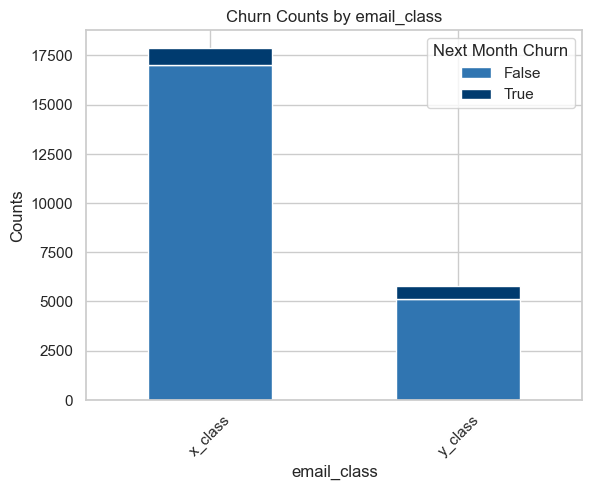

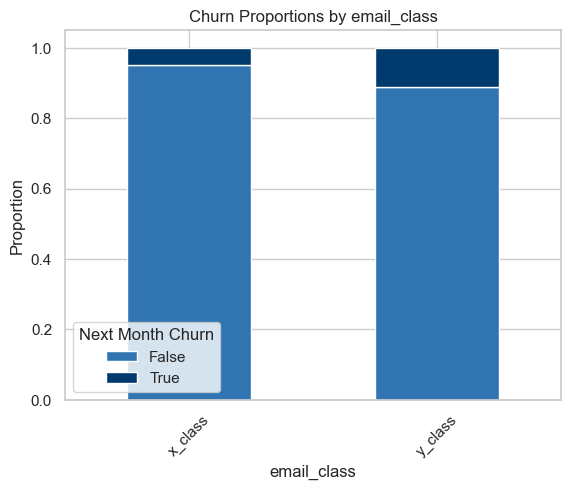

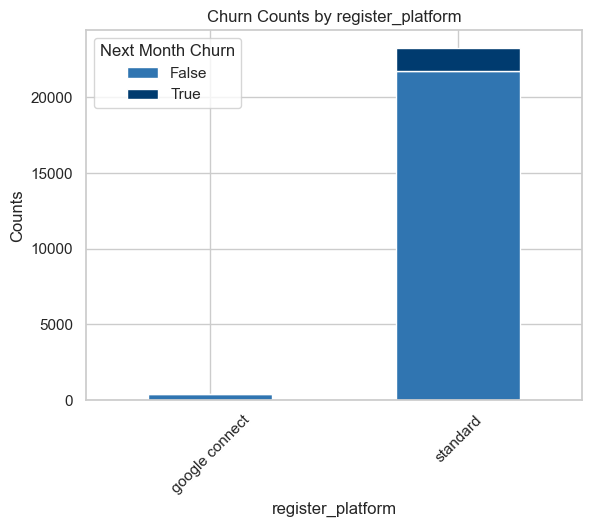

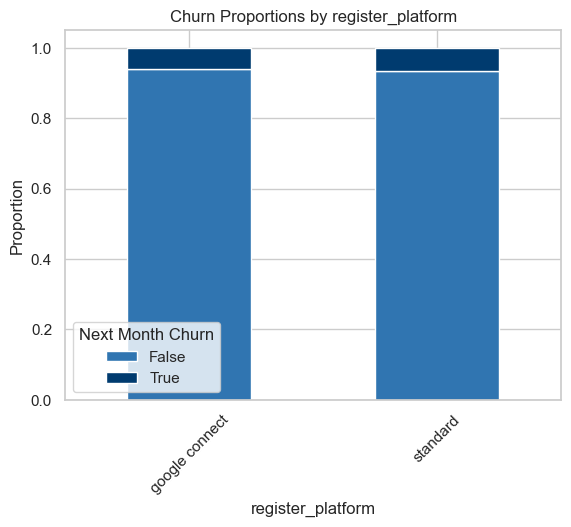

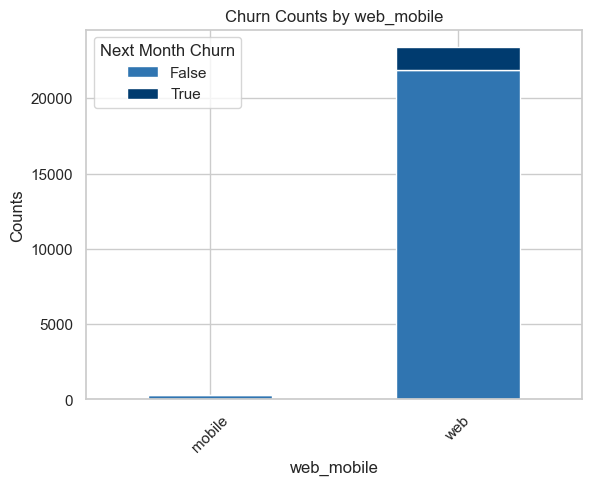

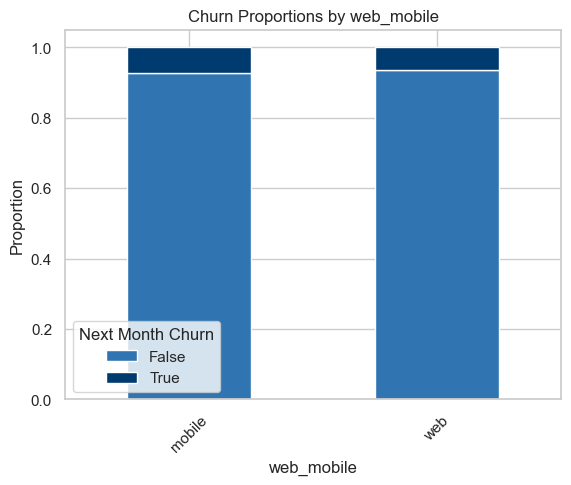

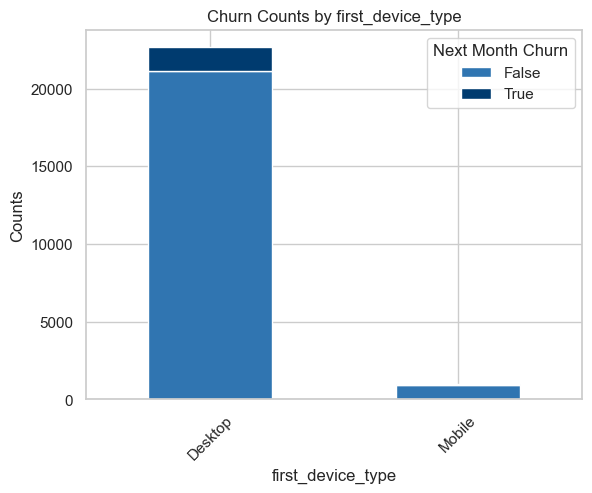

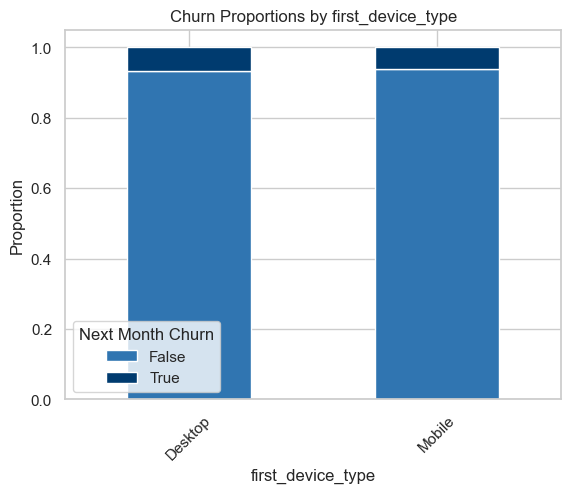

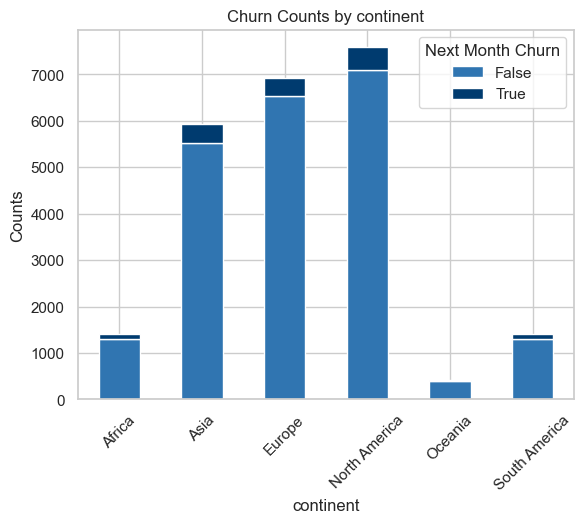

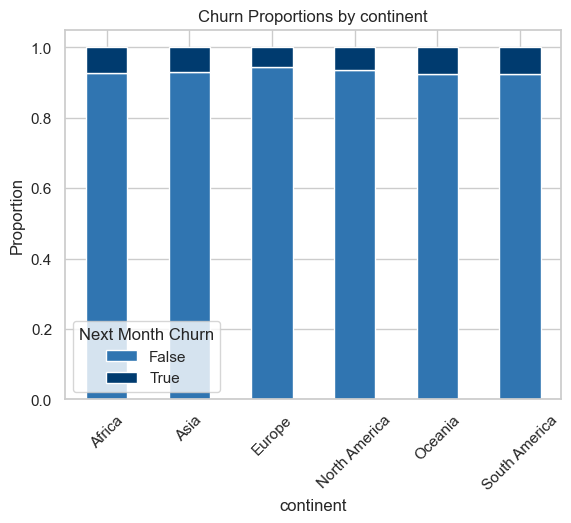

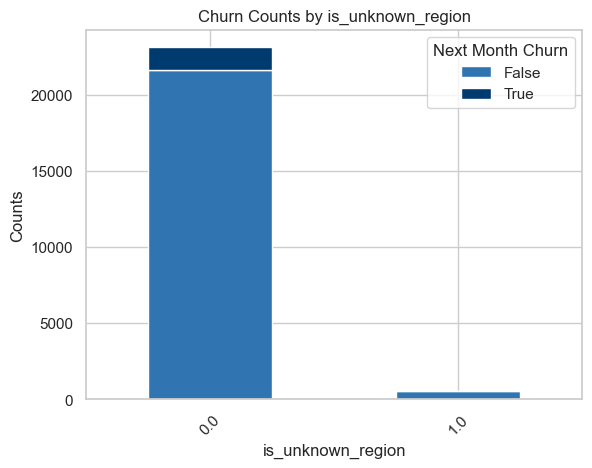

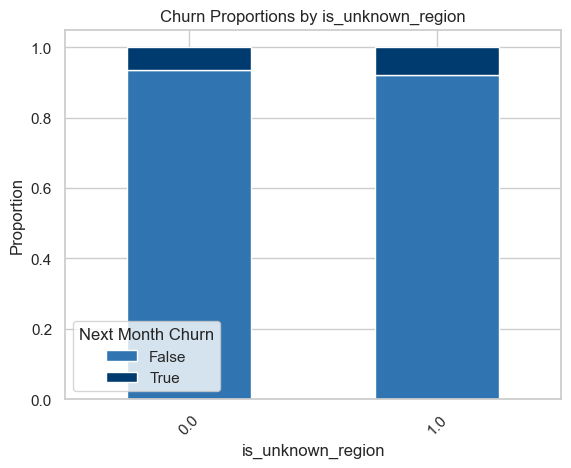

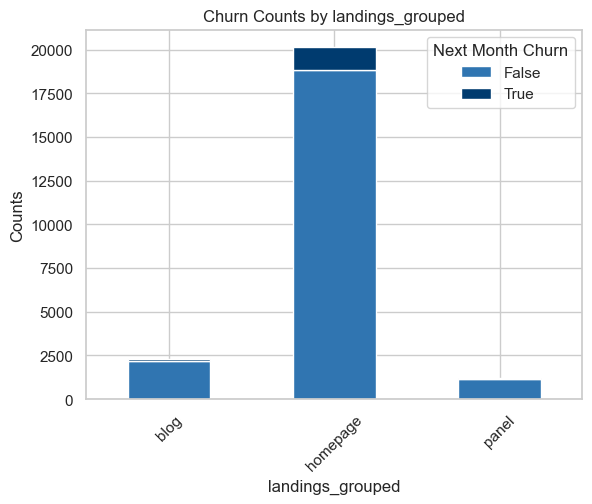

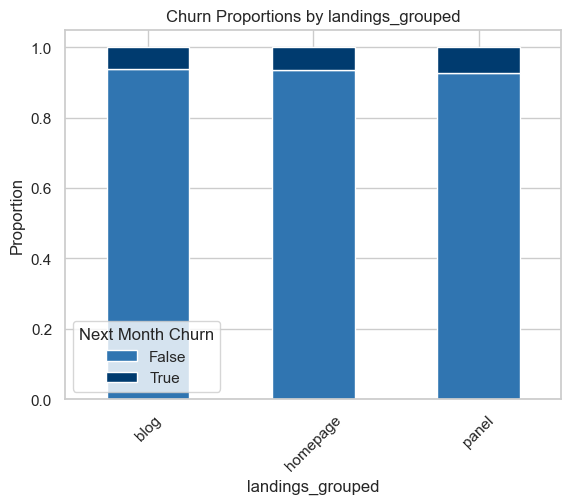

In [210]:
for c in categorical_cols: 
    plot_cat_vs_churn(df_monthly, c)

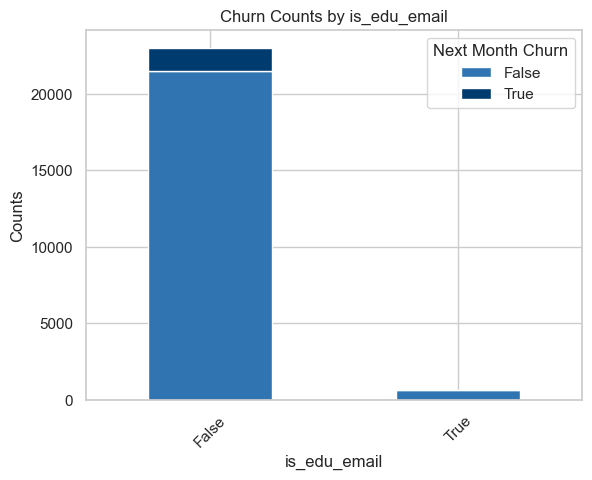

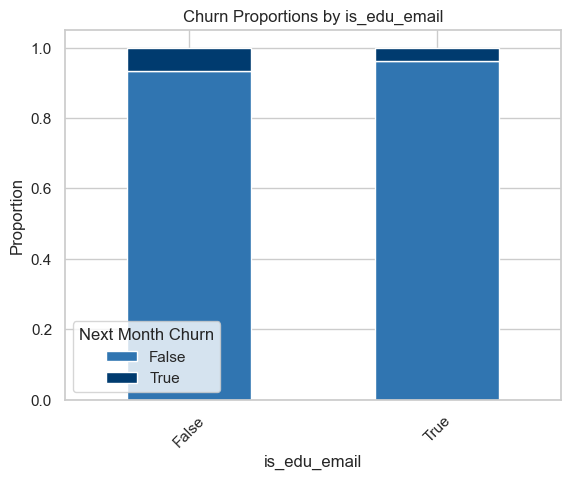

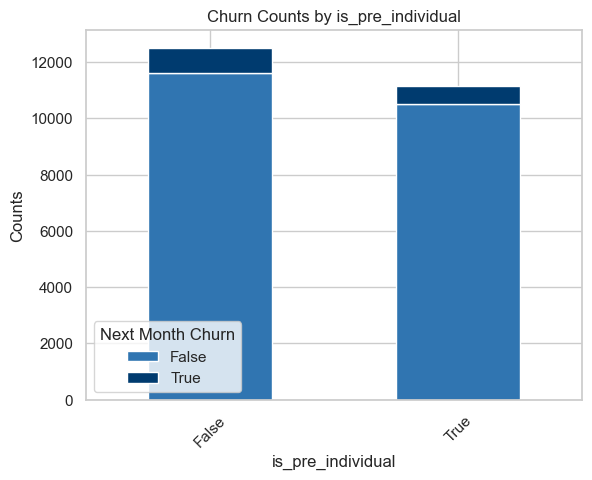

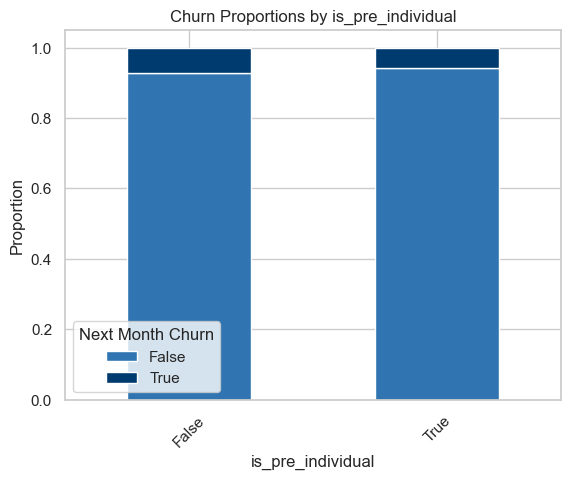

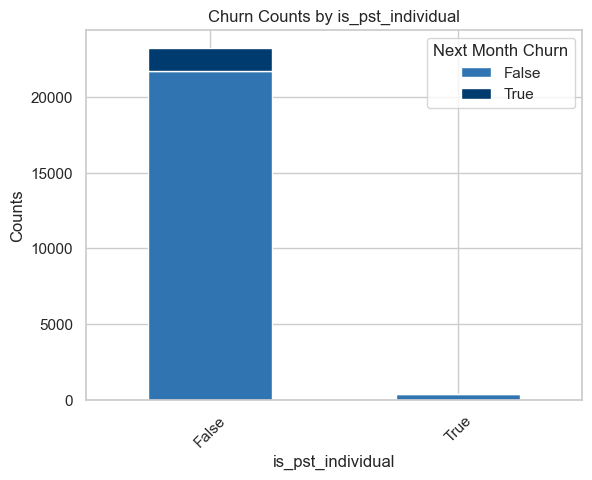

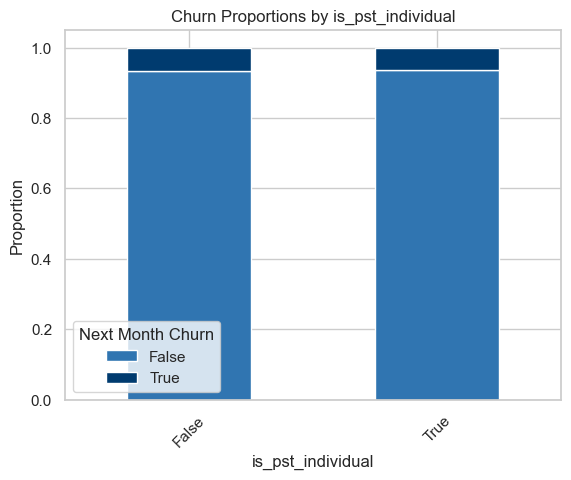

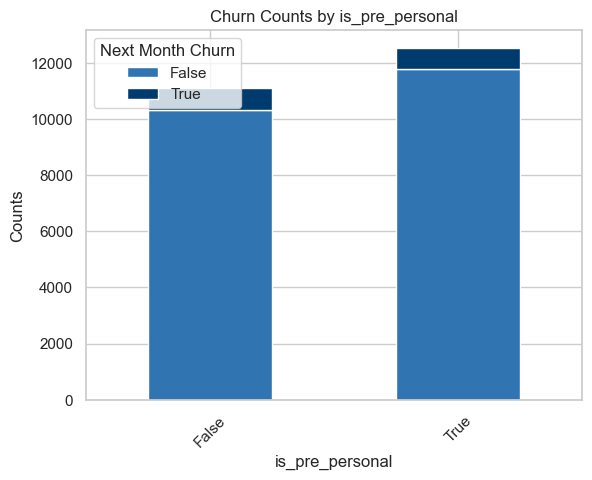

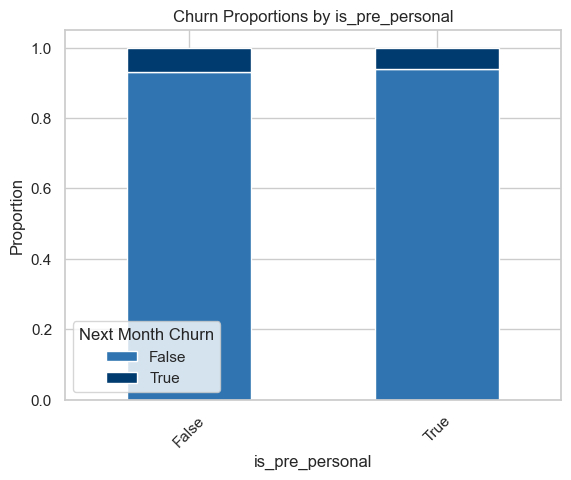

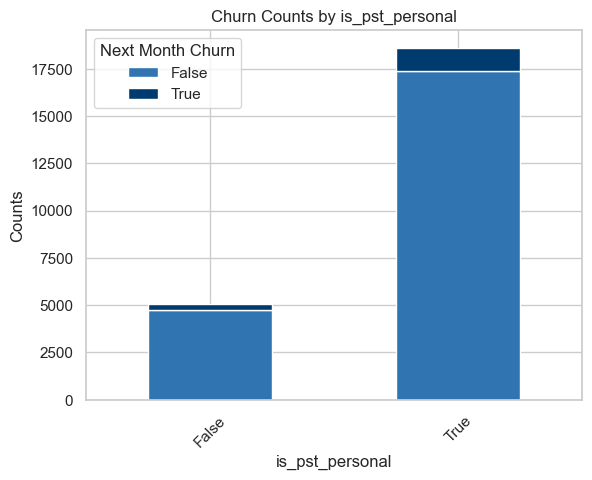

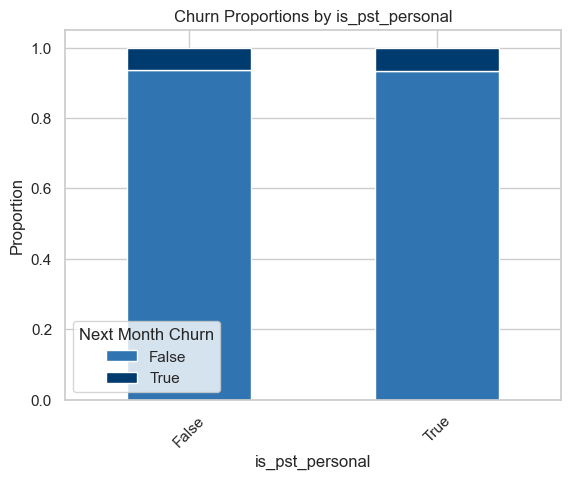

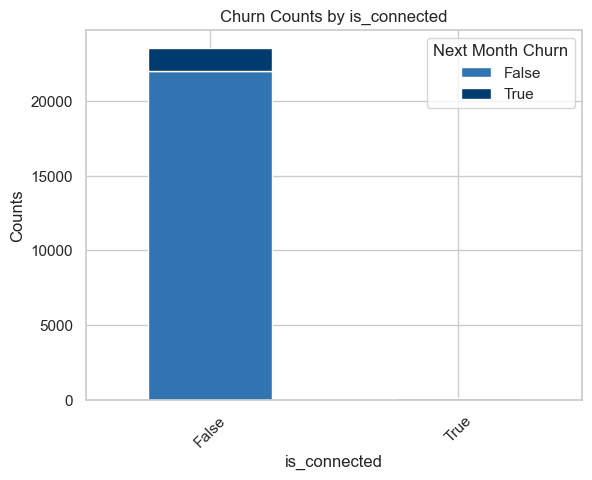

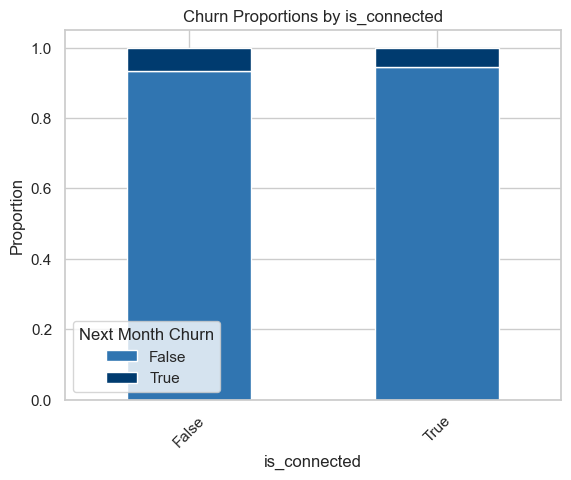

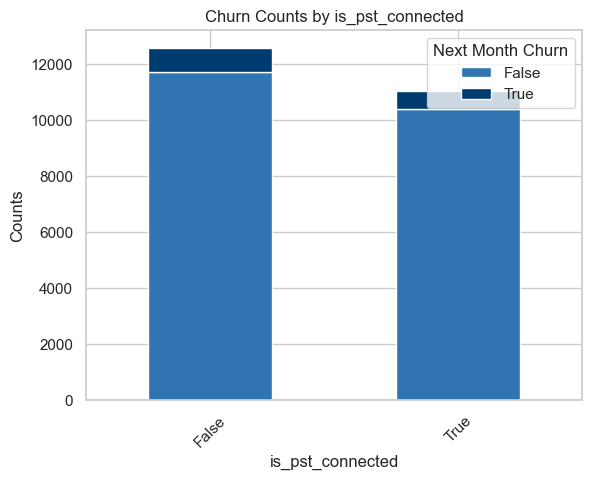

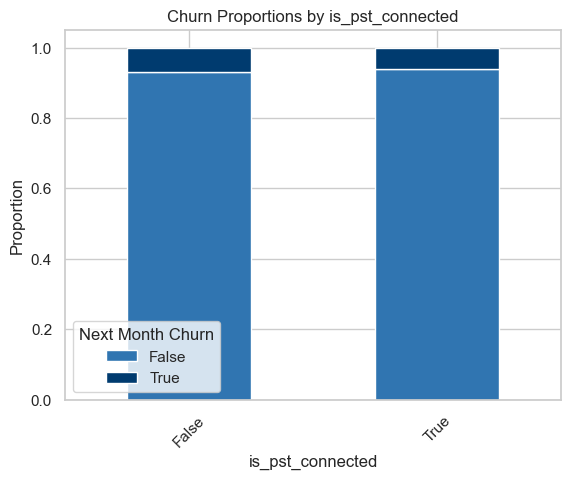

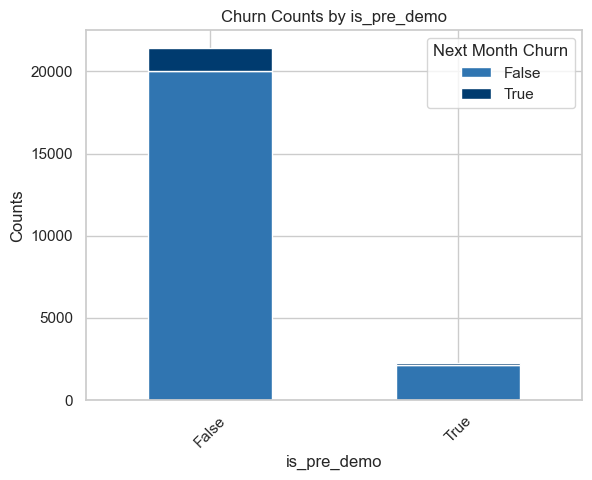

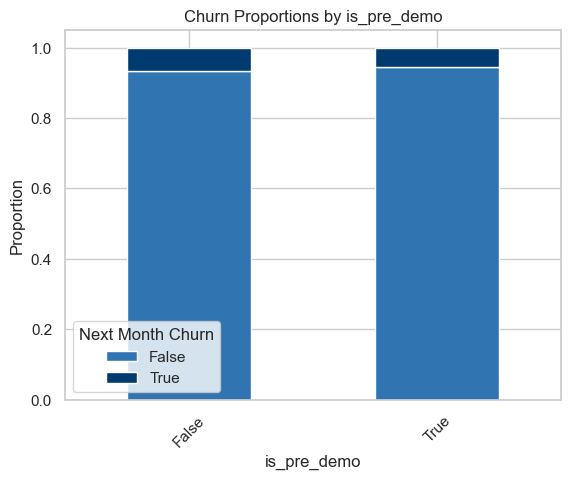

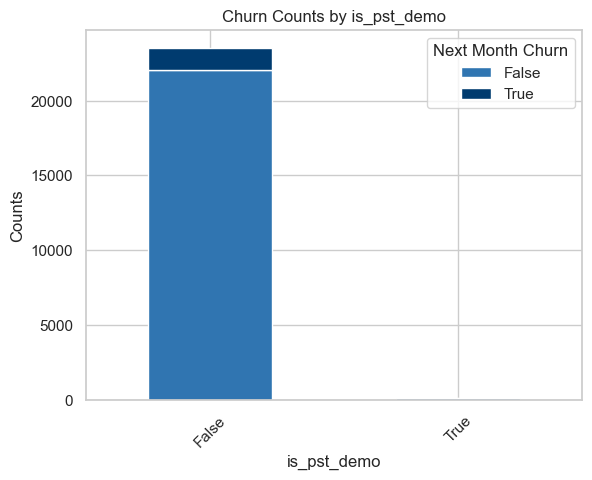

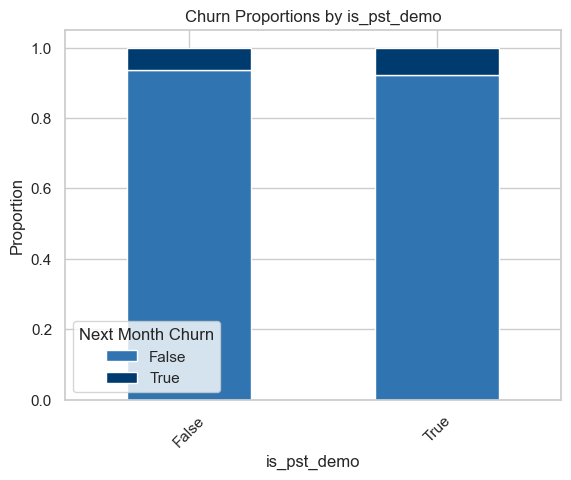

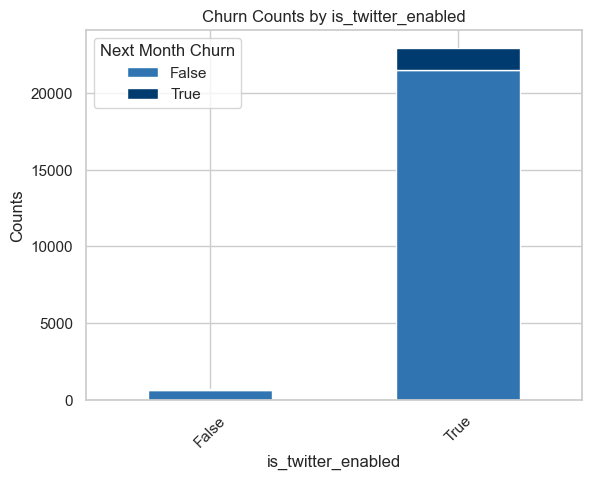

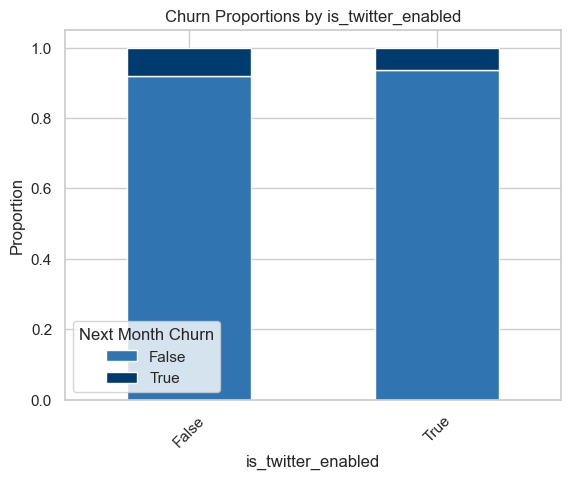

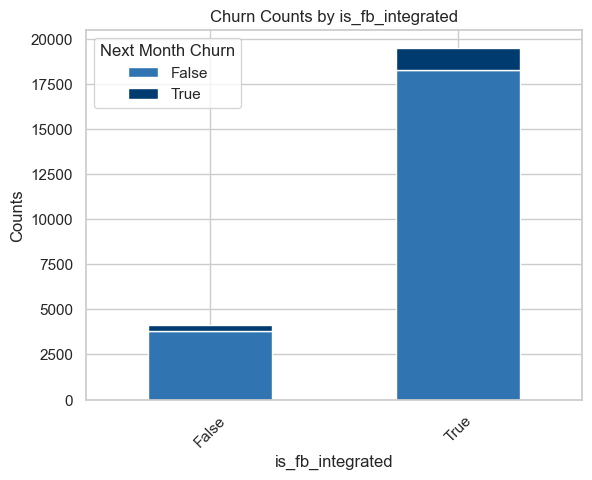

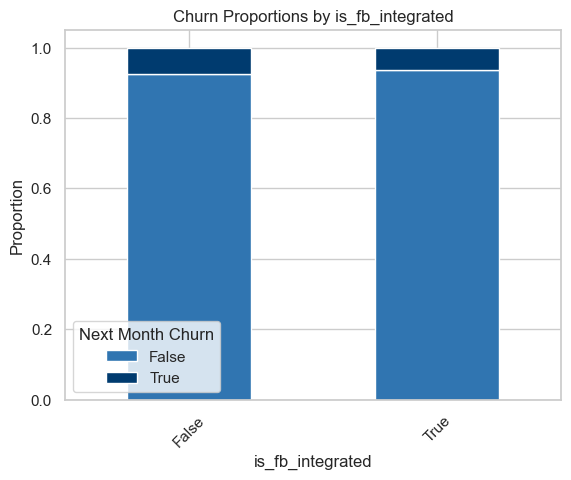

In [211]:
for c in flag_cols: 
    plot_cat_vs_churn(df_monthly, c)

In [212]:
num_cols

['mrr',
 'new_total_mentions',
 'sessions_nr',
 'total_pageviews_nr',
 'min_pv_nr',
 'max_pv_nr',
 'avg_pv_nr',
 'total_session_duration_min',
 'min_sess_min',
 'max_sess_min',
 'avg_sess_min',
 'users_nr',
 'users_limit',
 'subscription_month']

In [213]:
num_cols_to_plot = [c for c in num_cols if c not in ["users_limit", "subscription_month"]]
num_cols_to_plot

['mrr',
 'new_total_mentions',
 'sessions_nr',
 'total_pageviews_nr',
 'min_pv_nr',
 'max_pv_nr',
 'avg_pv_nr',
 'total_session_duration_min',
 'min_sess_min',
 'max_sess_min',
 'avg_sess_min',
 'users_nr']

In [214]:
sns.set(style="whitegrid")
num_cols_to_plot = [c for c in num_cols if c not in ["users_limit", "subscription_month"]]
df_monthly[df_monthly == np.Inf] = np.NaN

In [215]:
df_monthly_plot = df_monthly[num_cols_to_plot].copy()

# Applying the filter for each column separately
for column in num_cols_to_plot:
    cutoff = df_monthly_plot[column].quantile(0.95)  # Find the 90th percentile
    df_monthly_plot = df_monthly_plot[df_monthly_plot[column] < cutoff]  # Filter out the top 10% values

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


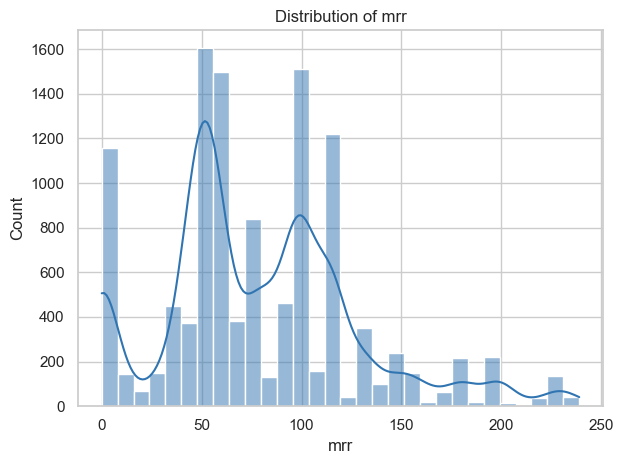

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


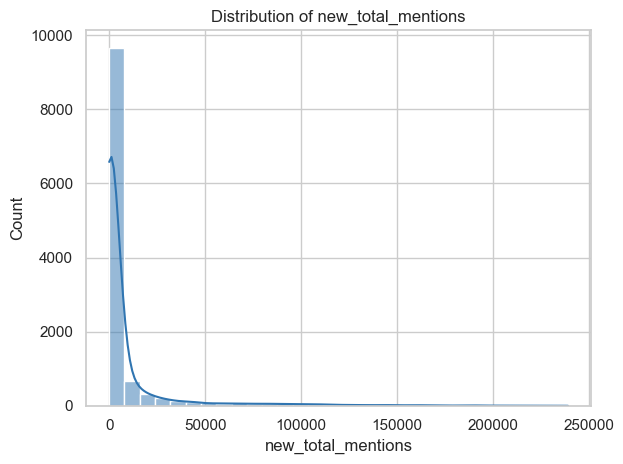

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


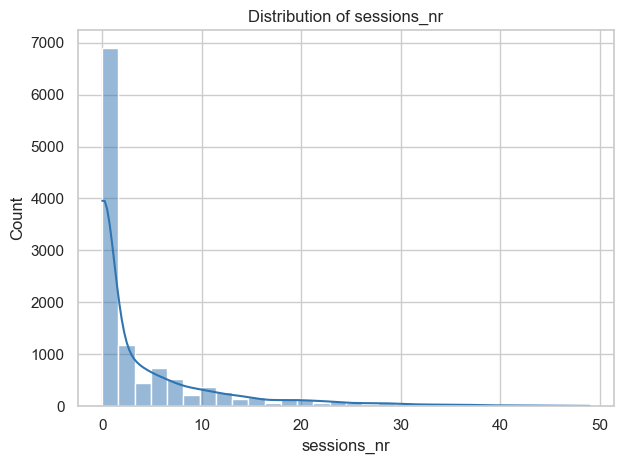

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


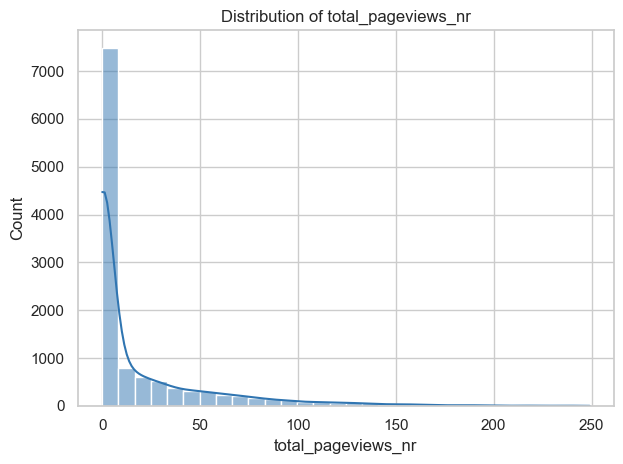

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


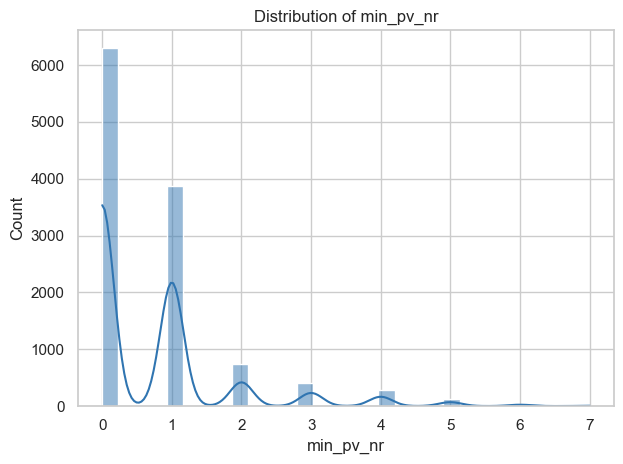

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


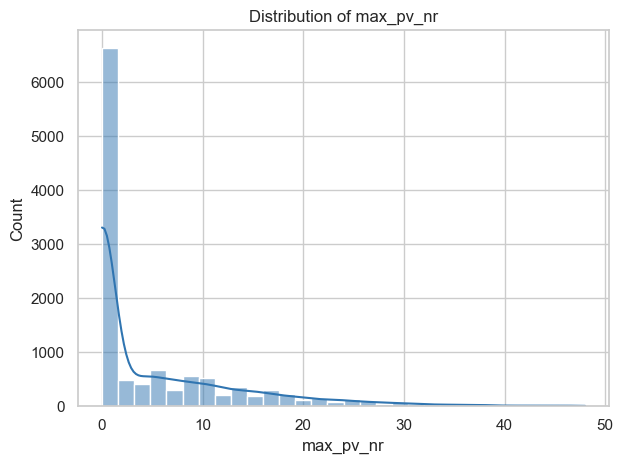

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


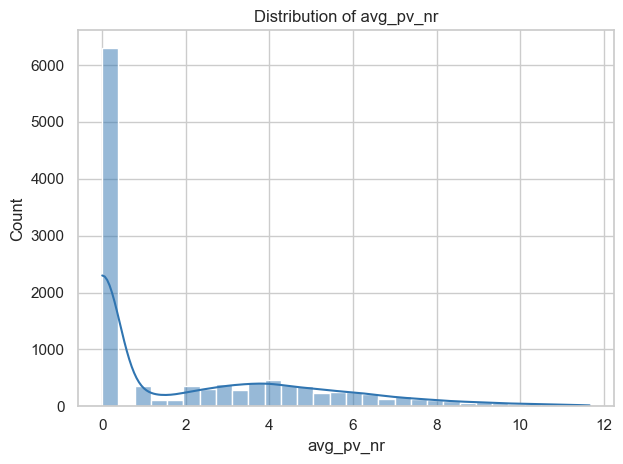

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


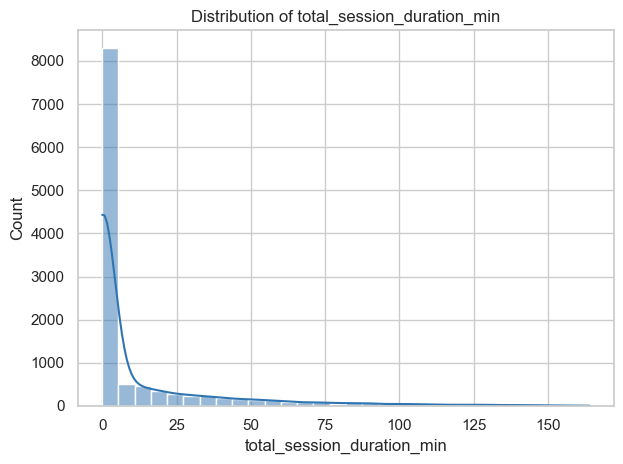

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


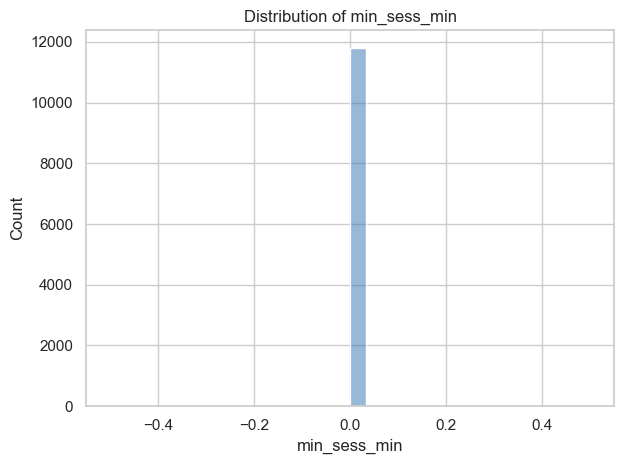

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


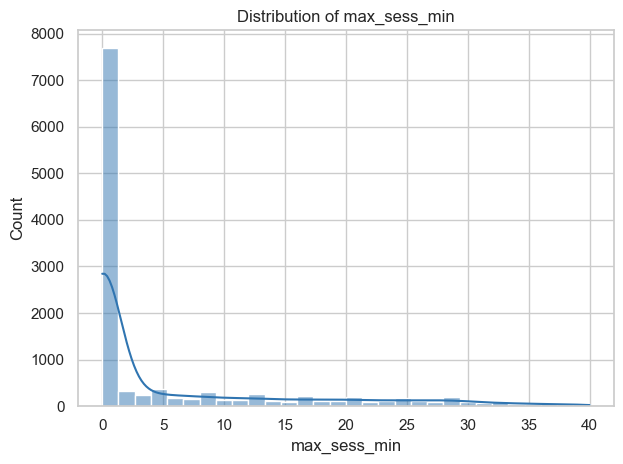

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


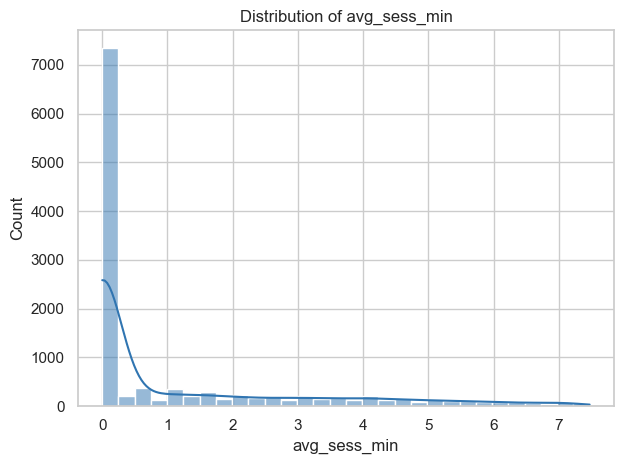

/Users/danielgawlowski/projects/python-sgh/venv-sim-bis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


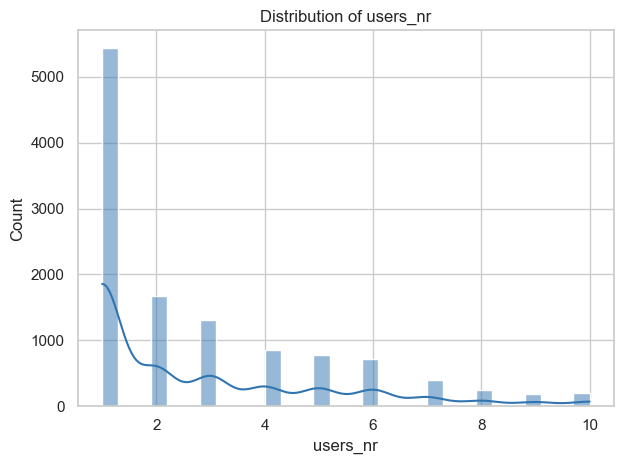

In [216]:
for i, col in enumerate(num_cols_to_plot, 1):
    sns.histplot(df_monthly_plot[col], kde=True, color='#3075B1', bins=30,)

    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

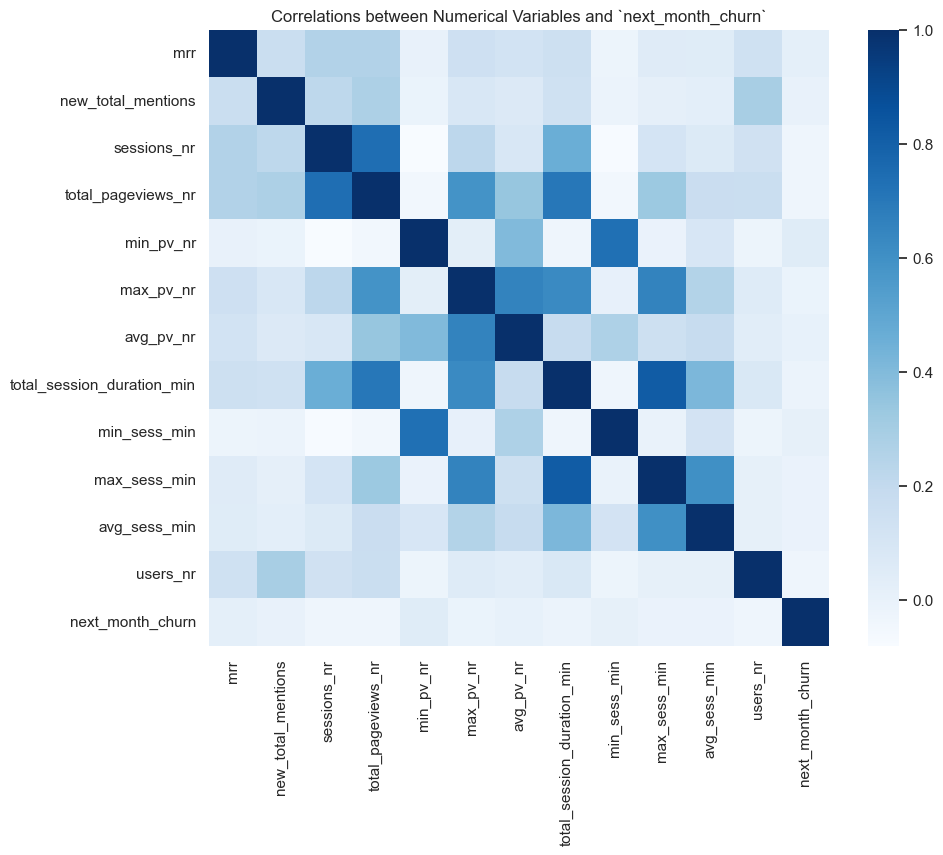

In [217]:
# Calculate correlations
correlations = df_monthly[num_cols_to_plot].join(df_monthly['next_month_churn']).corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, cmap="Blues")
plt.title('Correlations between Numerical Variables and `next_month_churn`')
plt.show()

In [218]:
correlations

,mrr,new_total_mentions,sessions_nr,total_pageviews_nr,min_pv_nr,max_pv_nr,avg_pv_nr,total_session_duration_min,min_sess_min,max_sess_min,avg_sess_min,users_nr,next_month_churn
mrr,1.000000,0.166523,0.258174,0.257674,0.000228,0.146064,0.122908,0.150050,-0.018540,0.054746,0.048339,0.143258,0.024331
new_total_mentions,0.166523,1.000000,0.216700,0.276511,-0.011823,0.089172,0.070082,0.141985,-0.012720,0.020795,0.028644,0.294838,0.002166
sessions_nr,0.258174,0.216700,1.000000,0.738752,-0.079932,0.222974,0.088939,0.461458,-0.073312,0.110920,0.066794,0.139399,-0.032089
total_pageviews_nr,0.257674,0.276511,0.738752,1.000000,-0.046148,0.587780,0.344434,0.701266,-0.045875,0.331445,0.170263,0.165563,-0.025135
min_pv_nr,0.000228,-0.011823,-0.079932,-0.046148,1.000000,0.031771,0.402649,-0.032003,0.731768,-0.005095,0.094030,-0.020001,0.049438
max_pv_nr,0.146064,0.089172,0.222974,0.587780,0.031771,1.000000,0.657587,0.628692,0.009765,0.656317,0.254557,0.057303,-0.009210
avg_pv_nr,0.122908,0.070082,0.088939,0.344434,0.402649,0.657587,1.000000,0.183319,0.273534,0.150851,0.183391,0.041808,0.007618
total_session_duration_min,0.150050,0.141985,0.461458,0.701266,-0.032003,0.628692,0.183319,1.000000,-0.025500,0.815256,0.417431,0.081469,-0.015085
min_sess_min,-0.018540,-0.012720,-0.073312,-0.045875,0.731768,0.009765,0.273534,-0.025500,1.000000,-0.001941,0.121187,-0.019227,0.016818
max_sess_min,0.054746,0.020795,0.110920,0.331445,-0.005095,0.656317,0.150851,0.815256,-0.001941,1.000000,0.602717,0.015498,-0.005914


In [219]:
def trend_factor(activities, terms=3):
    if len(activities) < terms:
        return np.nan
    weights = [i + 1 for i in range(terms)]
    a = np.sum([weights[i] * activities[i] for i in range(terms)])
    b = (terms / np.sum(weights))
    return a * b / np.sum(activities)


# Function to apply the trend factor for each eligible segment within a group
def apply_trend_to_group(group, column_name):
    # Ensure there's enough data to calculate the trend
    if len(group) < 3:
        return pd.Series([np.nan] * len(group), index=group.index)
    # Apply trend factor calculation for each point where possible
    trends = [trend_factor(group[column_name].iloc[max(0, i-2):i+1].tolist()) if i >= 2 else np.nan for i in range(len(group))]
    return pd.Series(trends, index=group.index)

In [220]:
# Columns to calculate the trend factor for
columns_to_calculate = [
    'mrr', 'new_total_mentions', 'sessions_nr', 'total_pageviews_nr',
    'min_pv_nr', 'max_pv_nr', 'avg_pv_nr', 'total_session_duration_min',
    'max_sess_min', 'avg_sess_min'
]

# Apply the trend calculation for each specified column and accounts_id group
for column in columns_to_calculate:
    trend_column = f'{column}_trend'
    # Initialize the column to store trend data if not already present
    if trend_column not in df_monthly.columns:
        df_monthly[trend_column] = pd.Series(dtype='float64')
    # Apply the trend factor calculation across the group
    df_monthly[trend_column] = df_monthly.groupby('accounts_id').apply(lambda x: apply_trend_to_group(x, column)).reset_index(level=0, drop=True)

/var/folders/68/0709rds552v9wln06jt3mwvr0000gn/T/ipykernel_39993/349236264.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a * b / np.sum(activities)
/var/folders/68/0709rds552v9wln06jt3mwvr0000gn/T/ipykernel_39993/2364283175.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_monthly[trend_column] = df_monthly.groupby('accounts_id').apply(lambda x: apply_trend_to_group(x, column)).reset_index(level=0, drop=True)
/var/folders/68/0709rds552v9wln06jt3mwvr0000gn/T/ipykernel_39993/349236264.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a * b / np.sum(activities)
/var/folders/68/0709rds552v9wln06jt3mwvr0000gn/T/ipykernel_39993/2364283175.py:15:

In [221]:
print(df_monthly.shape)

(23663, 46)


In [222]:
trend_cols = [c for c in df_monthly.columns if "_trend" in c] 

In [223]:
trend_cols

['mrr_trend',
 'new_total_mentions_trend',
 'sessions_nr_trend',
 'total_pageviews_nr_trend',
 'min_pv_nr_trend',
 'max_pv_nr_trend',
 'avg_pv_nr_trend',
 'total_session_duration_min_trend',
 'max_sess_min_trend',
 'avg_sess_min_trend']

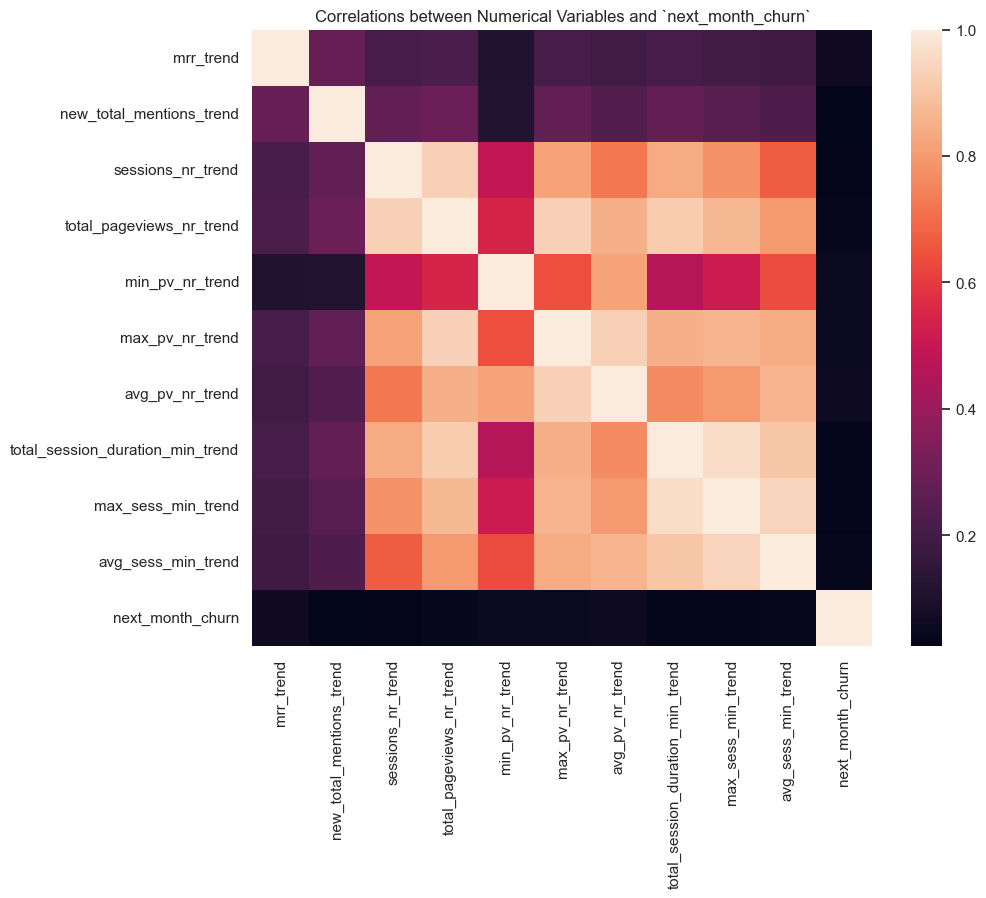

In [224]:
# Calculate correlations
correlations_trend = df_monthly[trend_cols].join(df_monthly['next_month_churn']).corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_trend)
plt.title('Correlations between Numerical Variables and `next_month_churn`')
plt.show()

In [225]:
correlations_trend

,mrr_trend,new_total_mentions_trend,sessions_nr_trend,total_pageviews_nr_trend,min_pv_nr_trend,max_pv_nr_trend,avg_pv_nr_trend,total_session_duration_min_trend,max_sess_min_trend,avg_sess_min_trend,next_month_churn
mrr_trend,1.000000,0.281294,0.211466,0.217870,0.110346,0.205926,0.191649,0.206424,0.199670,0.188035,0.063618
new_total_mentions_trend,0.281294,1.000000,0.271222,0.293399,0.113994,0.272475,0.229319,0.275721,0.252710,0.223990,0.025147
sessions_nr_trend,0.211466,0.271222,1.000000,0.929277,0.492578,0.819299,0.722875,0.839532,0.782321,0.666872,0.032659
total_pageviews_nr_trend,0.217870,0.293399,0.929277,1.000000,0.545169,0.934517,0.850990,0.918872,0.869178,0.795029,0.040982
min_pv_nr_trend,0.110346,0.113994,0.492578,0.545169,1.000000,0.639359,0.819344,0.457830,0.514448,0.637822,0.054378
max_pv_nr_trend,0.205926,0.272475,0.819299,0.934517,0.639359,1.000000,0.929983,0.850903,0.859682,0.836268,0.052662
avg_pv_nr_trend,0.191649,0.229319,0.722875,0.850990,0.819344,0.929983,1.000000,0.764732,0.797971,0.862283,0.056721
total_session_duration_min_trend,0.206424,0.275721,0.839532,0.918872,0.457830,0.850903,0.764732,1.000000,0.963925,0.904040,0.031843
max_sess_min_trend,0.199670,0.252710,0.782321,0.869178,0.514448,0.859682,0.797971,0.963925,1.000000,0.942047,0.034974
avg_sess_min_trend,0.188035,0.223990,0.666872,0.795029,0.637822,0.836268,0.862283,0.904040,0.942047,1.000000,0.040901


### Preparing for modelling

In [226]:
df_ready = df_monthly[df_monthly["subscription_month"] > 2].copy()

In [227]:
df_ready.shape

(20399, 46)

In [228]:
df_ready.isna().mean() 

date_month                          0.000000
accounts_id                         0.000000
plan_name                           0.000000
mrr                                 0.000000
new_total_mentions                  0.000000
sessions_nr                         0.000000
total_pageviews_nr                  0.000000
min_pv_nr                           0.000000
max_pv_nr                           0.000000
avg_pv_nr                           0.000000
total_session_duration_min          0.000000
min_sess_min                        0.000000
max_sess_min                        0.000000
avg_sess_min                        0.000000
email_class                         0.000000
is_edu_email                        0.000000
register_platform                   0.000000
web_mobile                          0.000000
first_device_type                   0.000000
continent                           0.000000
is_unknown_region                   0.000000
landings_grouped                    0.000000
is_pre_ind

In [229]:
df_ready = df_ready.fillna(1)

#### Train test split

In [230]:
cols_to_encode = [
    "email_class",
    "plan_name",
    "register_platform",
    "web_mobile",
    "first_device_type",
    "continent",
    "landings_grouped", 
]

In [231]:
unique_accounts = df_ready['accounts_id'].unique()

# Split unique users into training, test, and validation sets
train_users, temp_users = train_test_split(unique_accounts, test_size=0.3, random_state=41)  # 70% for training, 30% for temp (test + validation)
test_users, valid_users = train_test_split(temp_users, test_size=0.5, random_state=41)  # Split the 30% temp into 15% test and 15% validation

# Create DataFrames for each set based on the user splits
train_df = df_ready[df_ready['accounts_id'].isin(train_users)]
test_df = df_ready[df_ready['accounts_id'].isin(test_users)]
valid_df = df_ready[df_ready['accounts_id'].isin(valid_users)]

In [232]:
# Apply one-hot encoding to 'plan_name' columns in df_ready
df_ready_encoded = pd.get_dummies(df_ready, columns=cols_to_encode)

# Similarly, apply one-hot encoding to the training, testing, and validation sets
train_df = pd.get_dummies(train_df, columns=cols_to_encode)
test_df = pd.get_dummies(test_df, columns=cols_to_encode)
valid_df = pd.get_dummies(valid_df, columns=cols_to_encode)

In [233]:
features = df_ready_encoded.columns.difference(
    [target_col, 'accounts_id', 'date_month']
) 

X_train = train_df[features]
y_train = train_df[target_col]
X_test = test_df[features]
y_test = test_df[target_col]

X_valid = valid_df[features]
y_valid = valid_df[target_col]

# Encode the target variable if it's not already numeric
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

y_valid = le.transform(y_valid)

### Logistic regression baseline

In [234]:
# Identify numerical columns - adjust as necessary if you have specific columns to include or exclude
numerical_cols = X_train.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns

In [235]:
# Define the preprocessing steps for numerical columns
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardizes the data
])

# Combine the preprocessing steps
# If you have categorical data to preprocess, add another transformer here
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)
        # Add other transformers here for categorical data if needed
    ],
    remainder='passthrough'  # Indicates what to do with columns not explicitly selected
)

# Apply the preprocessing pipeline to the feature data
# This does not include the target variable
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.fit_transform(X_test)
X_valid_preprocessed = preprocessor.fit_transform(X_valid)

In [236]:
lr = LogisticRegression()
lr.fit(X_train_preprocessed, y_train)

LogisticRegression()

In [237]:
# Predict on the test set
y_pred_lr = lr.predict(X_test_preprocessed)
y_pred_proba_lr = lr.predict_proba(X_test_preprocessed)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred_lr, digits=4, target_names=["Not churned", "Churned"]))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_lr))

              precision    recall  f1-score   support

 Not churned     0.9302    0.9940    0.9610      2656
     Churned     0.2000    0.0198    0.0360       202

    accuracy                         0.9251      2858
   macro avg     0.5651    0.5069    0.4985      2858
weighted avg     0.8786    0.9251    0.8957      2858

ROC-AUC Score: 0.6464943934152451


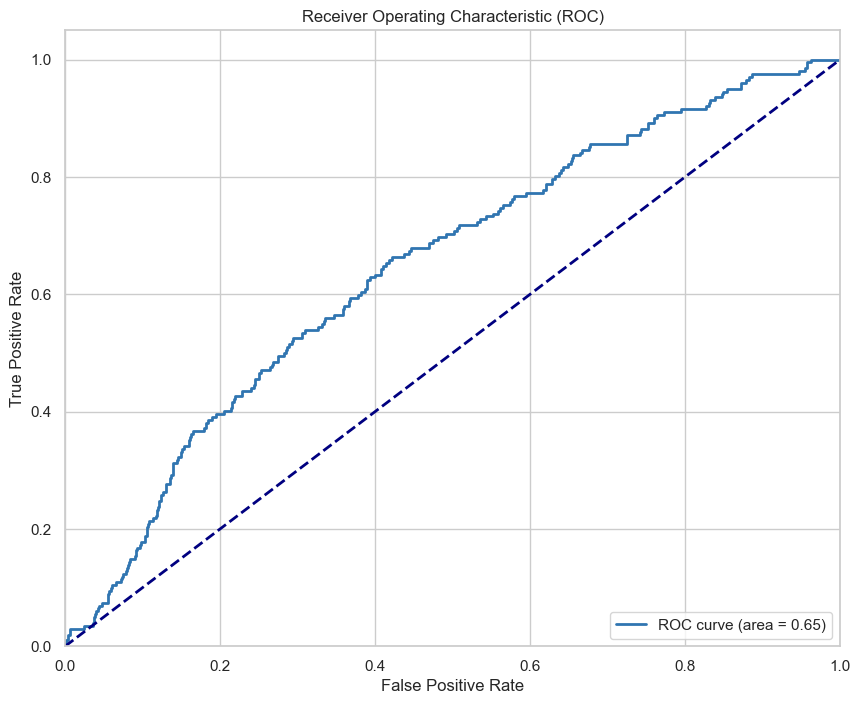

In [238]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='#3075B1', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

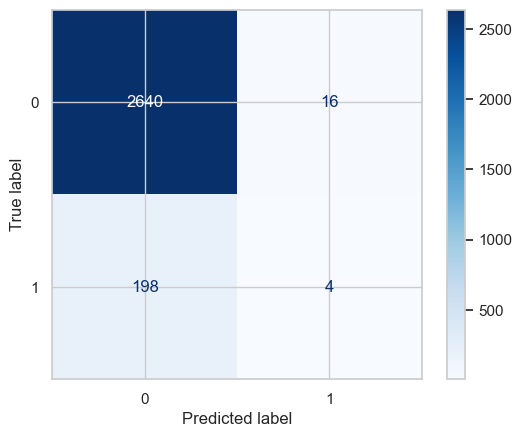

In [239]:
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

### XGBoost

In [240]:
from sklearn.metrics import recall_score, f1_score, precision_score

In [241]:
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        # 'eval_metric': 'recall',
        'booster': 'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
    }
    
    # Train the model
    model = xgb.XGBClassifier(**param)
    
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)
    
    # Predict and calculate ROC-AUC score
    preds = model.predict_proba(X_valid)[:,1]
    roc_auc = roc_auc_score(y_valid, preds)

    pred_labels = model.predict(X_valid)

    recall = recall_score(y_valid, pred_labels)
    f1 = f1_score(y_valid, pred_labels)
    precision = precision_score(y_valid, pred_labels) 
    
    return f1, roc_auc

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective, n_trials=100)

# Best trial
trial = study.best_trial
print(f'ROC-AUC: {trial.value}')
print("Best hyperparameters: {}".format(trial.params))

[I 2024-02-27 20:15:32,455] A new study created in memory with name: no-name-c7bb6a7e-36f2-4be7-ae99-3f19f80b24e0
/var/folders/68/0709rds552v9wln06jt3mwvr0000gn/T/ipykernel_39993/3797769003.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
/var/folders/68/0709rds552v9wln06jt3mwvr0000gn/T/ipykernel_39993/3797769003.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
/var/folders/68/0709rds552v9wln06jt3mwvr0000gn/T/ipykernel_39993/3797769003.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See http

RuntimeError: A single best trial cannot be retrieved from a multi-objective study. Consider using Study.best_trials to retrieve a list containing the best trials.

In [242]:
study.best_trials

[FrozenTrial(number=19, state=TrialState.COMPLETE, values=[0.3333333333333333, 0.7468714154770565], datetime_start=datetime.datetime(2024, 2, 27, 20, 15, 37, 52094), datetime_complete=datetime.datetime(2024, 2, 27, 20, 15, 37, 490223), params={'lambda': 1.3250796759090278e-07, 'alpha': 0.0004919738645863665, 'max_depth': 8, 'eta': 0.023075979254916935, 'scale_pos_weight': 10.268542598258431, 'subsample': 0.873485522710572, 'colsample_bytree': 0.7915701870530925}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'lambda': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'alpha': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'max_depth': IntDistribution(high=9, log=False, low=3, step=1), 'eta': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'scale_pos_weight': FloatDistribution(high=100.0, log=False, low=1.0, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.2, step=None), 'colsample_b

In [251]:
# best params from optuna
best_params = {
    'lambda': 1.33e-07, 
    'alpha': 0.0005, 
    'max_depth': 8, 
    'eta': 0.023, 
    'scale_pos_weight': 11, 
    'subsample': 0.87,
    'colsample_bytree': 0.7915701870530925
}

In [252]:
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(alpha=0.0005, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7915701870530925, device=None,
              early_stopping_rounds=None, enable_categorical=False, eta=0.023,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1.33e-07, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, ...)

In [253]:
# Predict on the test set
y_pred = model.predict(X_test)

y_pred_proba = model.predict_proba(X_test)[:, 1] 

# Evaluation
print(classification_report(y_test, y_pred, digits=4, target_names=["Not churned", "Churned"]))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

 Not churned     0.9507    0.8863    0.9174      2656
     Churned     0.2094    0.3960    0.2740       202

    accuracy                         0.8516      2858
   macro avg     0.5801    0.6412    0.5957      2858
weighted avg     0.8983    0.8516    0.8719      2858

ROC-AUC Score: 0.74185013569128


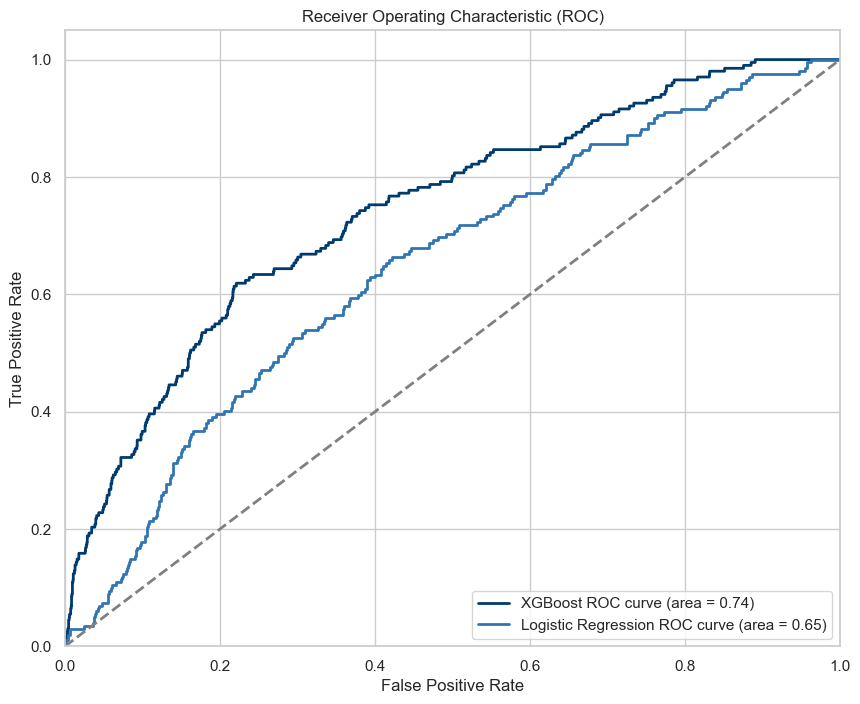

In [254]:
# Assuming y_test contains true labels and y_pred_proba contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Calculate AUC

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#003B6F', lw=2, label='XGBoost ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_lr, tpr_lr, color='#3075B1', lw=2, label='Logistic Regression ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

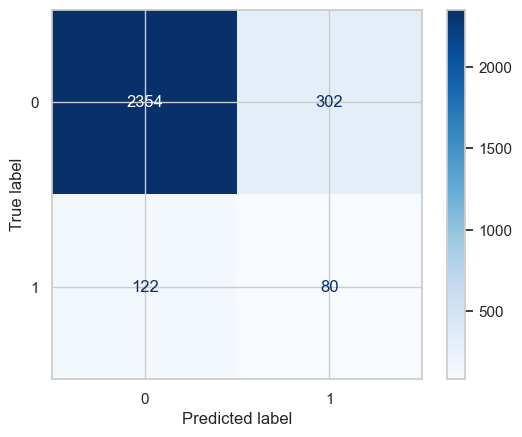

In [255]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Display
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [256]:
feature_importances = model.get_booster().get_score(importance_type='weight')

In [257]:
feature_importances_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

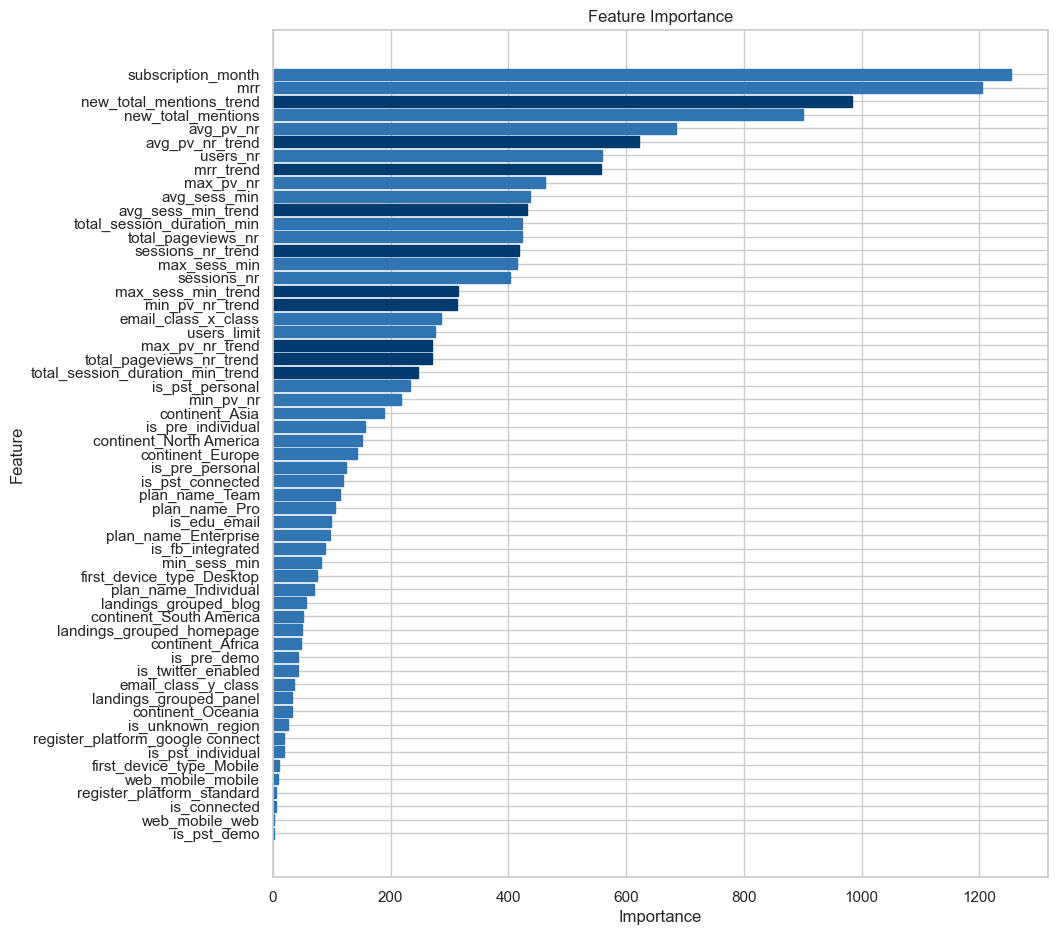

In [258]:
plt.figure(figsize=(10, 11))
bars = plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])

# Iterate over the bars and the feature names together
for bar, feature in zip(bars, feature_importances_df['Feature']):
    if 'trend' in feature:
        bar.set_color('#003B6F')
    else:
        bar.set_color('#3075B1')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()